# Scaling up designs in synthetic biology using _Pacti_

Research in synthetic biology has accelerated in the past decade due to its enormous promise in engineering biological systems for desired behavior ([here's a review article on synthetic biology](https://www.cell.com/trends/plant-science/fulltext/S1360-1385(15)00049-7), and [here's another](https://onlinelibrary.wiley.com/doi/abs/10.1002/anie.201609229)). Applications range from biomedicine to engineered living materials and environmental remediation. From a design standpoint, mathematical models have been used to study the behavior of biological systems and analyze various properties (see for example [this modeling paper](https://pubs.acs.org/doi/10.1021/acssynbio.2c00534)). However, current experimental design approaches in synthetic biology are largely heuristics and trial-and-error based, hence, difficult to scale. To alleviate this, various modeling and analysis and logic gate design tools (like [Cello](https://www.nature.com/articles/s41596-021-00675-2)) have been proposed but none have yet been used to successfully design large biological circuits. We believe that the _Pacti_ framework holds the potential to address this issue of scale due to its generality in writing system specifications and in decoupling the modeling details of each component from their specification. 

![main_figure](main_figure.png)

Some notes on the biological jargon in this notebook:
0. Genetic circuit: A biological system (DNA/group of DNA/DNA and other enzymes, or any other engineered biological system)
1. Protein Expression: This simply means the process of production of a protein, often used when talking about the quantitiy of the protein that is produced.
2. Inducer: A chemical that is used as an input to "induce" a system, that is, a chemical that switched something ON.
3. Plasmid: A plasmid is a small DNA molecule within a cell. Often used interchangeably in this notebook with a "gene".
4. Regulator: A system or a molecule that controls (regulates) something else (expression of a protein or a chemical or enzyme).
5. RPU: This stands for relative promoter units, this is a commonly used unit to measure the quantity of a protein output. You can think of RPU as an analogoue of concentration of a protein.
6. Fold-change: The ratio between the ON and the OFF level of something. You can think of fold-change as "SNR" - the ratio between the output of the system when it is ON (there is a signal that we measure, in this case, RFP) and when it is OFF (so there is only some noisy output, which we refer to as the "leak value of RFP").

This case study shows the use of Pacti to aid the design of engineered biological circuits for altering and observing the dynamics of bacterial gene transfer in soil and its effects on protein expression in plants (schematic shown in Figure A above). As the full system design is large, we focus on the design of a biological NAND gate system. This system has three subsystems, as shown in Figure B. We will use contract _composition_ as part of an optimization strategy to maximize the system fold-change, defined as the ratio between the on and off levels of the system's output. The _quotient_ will be used to infer a specification of a missing subsystem that needs to be designed in our system. We say that an input or an output is "ON" when its level is higher than a minimum  threshold, and is "OFF" when its level is lower than a maximum threshold. We formalize these notions with polyhedral constraints in the contract descriptions. 

The biological NAND gate consists of the three subsystems:

1) a sensor with tetracycline (aTc) input that outputs a dCas9 protein, 

2) another sensor (to be chosen) that outputs the xRFP-gRNA protein, and 

3) a dCas9 repressor subsystem, which takes as inputs the xRFP-gRNA and the dCas9 proteins. 

When both inputs to this repressor subsystem are ON, it suppresses the output, RFP, a red fluorescent protein. RFP is also the output of the top-level system. RFP is ON only when either of the sensors inputs are OFF. In this way, the system behavior is that of a NAND logic gate. We will denote the contract for the tetracycline sensor as $C_{\text{aTc}}$, and the contract for dCas9 repression mechanism as $C_{\text{dCas9}}$. Our first task will be to find the second sensor (choose spec for subsystem 2) that maximizes the top-level system fold-change. Then we will consider the task of finding a specification for the repression component (subsystem 3) assuming that the contracts for both sensors and the top-level system are available.

Biological motivation: 

The input in this system design is a target gene of interest introduced in the soil through bacteria. The goal is to measure the protein expression of the plant in response to the target gene input. The way we detect whether this gene is present is with many different complex biological processes and the output of whether we detect the gene, is "read out" from the plant leaf. So, the input is the gene of interest that we want to detect and the output is the protein production out of the plants (measured as protein fluorescence). Designing such a biological system is difficult due to the lack of information about key biological mechanisms, absence of characterization data for system parts, unknown effects of the soil context, etc. There are many biological processes that would need to be engineered to build a system like this but we focus on a small part of it => the engineered bacteria (see Figure). We assume that the top-level designer has asked us to design this functionally complete bacteria as a NAND gate to serve the overall purpose. To optimize the design, we would like the bacterial system to maximize its fold-change, that is, maximize the ratio of its output in the on and the off levels (fold-change = output on / output off). 

To summarize, we address the following three tasks in this notebook:

1. Characterized library of parts as assume-guarantee contracts: Using existing experimental data from literature, we present a library of sensors as assume-guarantee contracts that can be used to reason about specifications of diverse biological circuits. For the engineered bacteria case study, we use previously published data (for the Marionette cell lines) to construct a library of 14 sensors.
2. Speeding up the experimental design: Current experimental design approaches in synthetic biology are heavily reliant on screening experiments where all possible choices are explored experimentally to choose the one that works. This is not only time consuming and expensive but also does not scale beyond three or four independent choices. With the use of _Pacti_ , we demonstrate how scientists may describe the desired top-level behavior as contracts and then computationally choose from a library of available parts to ensure that the components meet the top-level system specification. For the engineered bacteria case study, we find the specification of the sensors that meet the top-level criteria on fold-change of the circuit response.
3. Finding specifications of missing parts: In synthetic biology, it is common to have parts in the system for which no characterization data is available. Using quotient operation on contracts, we can find the constraints that this missing part must satisfy to meet the desired top-level criteria. For the bacterial case study, we find the missing contract of the dCas9-mediated repression mechanism (as shown in the B panel of the Figure above) for which characterization data is not available in the literature.

# Modeling the specifications to construct a library of parts

Using the experimental characterization data for the sensors in the _Marionette_ bacterial cell strain [1], we model the sensor behavior as assume-guarantee contracts. We observe that each sensor has three characteristic behaviors: (1) the off state, where the output of the sensor stays close to zero (the non-zero expression in this state is termed as "leaky response"), (2) the linear rate of output , where the sensor output responds linearly to the input (in log scale), (3) the saturation state, where the sensor output saturates to a maximum constant v

[1] Meyer, Adam J., et al. "Escherichia coli “Marionette” strains with 12 highly optimized small-molecule sensors." Nature chemical biology 15.2 (2019): 196-204.

In [7]:
# Load the Pandas library to read experimental data from the Marionette paper [1]
import pandas as pd

In [8]:
# Read the data from the paper using the CSV file "marionette_data.csv"
df = pd.read_csv("marionette_data.csv", delimiter=",", engine="python")

df

,Inducer,Plasmid,Regulator,Promoter,ymax (RPU),ymin (RPUx10-3),K (µM),n,Dynamic range,start,ymax Linear
0,DAPG,pAJM.847,PhlFAM,PPhlF,2.50,2.5,1.700,2.1,1000,0.0300,2.00
1,Cuma,pAJM.657,CymRAM,PCymRC,3.70,4.3,8.900,2.4,870,0.3000,2.00
2,OC6,pAJM.474,LuxR,PLuxB,1.30,2.4,0.120,1.8,540,0.0020,0.50
3,Van,pAJM.773,VanRAM,PVanCC,3.00,2.4,26.000,2.3,1200,1.0000,1.80
4,IPTG,pAJM.336,LacIAM,PTac,3.30,4.8,140.000,1.8,690,2.0000,1.50
5,aTc,pAJM.011,TetR,PTet*,2.40,4.9,0.013,3.8,500,0.0018,1.00
6,Ara,pAJM.677,AraCAM,PBAD,1.20,2.4,37.000,1.5,500,0.2000,0.70
7,Cho,pAJM.683,BetIAM,PBetI,2.60,8.5,4100.000,2.7,310,300.0000,0.90
8,Nar,pAJM.661,TtgRAM,PTtg,0.46,3.4,95.000,1.9,140,2.0000,0.20
9,DHBA,pAJM.690,PcaUAM,P3B5B,1.60,4.5,370.000,1.8,360,9.0000,1.00


Create contracts for the sensor using this experimental data:

In [9]:
# Import pacti PolyhedralContract class to read contracts
from pacti.terms.polyhedra import PolyhedralContract

def create_sensor_contracts(sensor_input="AHL", output="FP", K=0.0, yleak=0.0, start = 0.0, ymax_lin = 0.0):
    """
    Creates the contracts for a Marionette sensing subsystem
    params:
        * input (str): The inducer input to the sensor
        * output (str): The output of the genetic construct. Inducer activates the
                        production of this output
        * K (float): The value of the Hill activation parameter K
        * yleak (float): The minimum expression of output even in absence of inducer
        * start (float): The value of inducer at which the induction starts
        * ymax_lin (float): The maximum expression of output by the inducer
                            before saturating (the end of linear regime)
    """
    slope = (ymax_lin - yleak)/(K - start)
    intercept = yleak - slope*start
    contract_0 = PolyhedralContract.from_string(
            input_vars = [
                sensor_input
            ],
            output_vars = [
                output
            ],
            assumptions = 
            [
                f"{sensor_input} <= {start}"
            ],
            guarantees = [
                f"{output} <= {yleak}"
            ]
    )
    contract_lin = PolyhedralContract.from_string(
            input_vars = [
                sensor_input
            ],
            output_vars = [
                output
            ],
            assumptions = 
            [
                f"{sensor_input} <= {K}",
                f"-{sensor_input}<={-1*start}"
            ],
            guarantees = [
                f"-{output} + {slope}{sensor_input}<={intercept}",
                f"{output} - {slope}{sensor_input}<={-1*intercept}"
            ]
    )
    contract_max = PolyhedralContract.from_string(
            input_vars = [
                sensor_input
            ],
            output_vars = [
                output
            ],
            assumptions = 
            [
                f"-{sensor_input}<={-1*K}"
            ],
            guarantees = [
                f"-{output}<={-1*ymax_lin}"
            ]
    )
    return contract_0, contract_lin, contract_max

## Composition to find optimal sensor choices

To speed up the experimental screening, we use _Pacti_ to choose a sensor from the library that meets the desired top-level behavior. Here, we have a tetracycline (aTc) sensor that expresses a dCas9 protein and the other sensor (the one we want to choose) that expresses the xRFP guide RNA. The xRFP guide RNA binds to dCas9 to repress the expression of red fluorescent protein (RFP), the output of the system. When either of the sensors are OFF, the output (RFP) is constitutively expressed (that is, output is ON). In this way, the system behavior is that of a NAND logic gate. We denote the contract for the tetracycline sensor as $C_{\text{atc}}$ and the contract for dCas9 repression mechanism as $C_{\text{dCas9}}$. For the top-level specification, we define the fold-change of the system as
$F = \frac{\text{RFP}_{\text{on}}}{\text{RFP}_{\text{off}}}.$

To choose the sensor that achieves the highest fold-change for the system, we compose the contract for each of the available 13 sensors in the library with the tetracycline contract and the dCas9 repression contract to obtain the top-level system contract. The composition operation in _Pacti_ reports a design error for any sensor that is "unsatisfiable in the given context" to reject some of the choices while some other choices are rejected if they do not meet the set top-level system criteria.

In [10]:
# Create all sensor contracts:
sensor_names = [str(i) for i in df["Inducer"]]
sensor_library = {}
sensor_library_params = {}
for sensor in sensor_names:
    sensor_params = {}
    yleak_s = df.loc[df["Inducer"] == sensor]["ymin (RPUx10-3)"].values[0] * 1e-3
    s_start = df.loc[df["Inducer"] == sensor]["start"].values[0]
    s_K = df.loc[df["Inducer"] == sensor]["K (µM)"].values[0]
    ymax_s = df.loc[df["Inducer"] == sensor]["ymax Linear"].values[0]
    sensor_params = {"leak": yleak_s, "start": s_start, "K": s_K, "ymax": ymax_s}
    s_output = "dCas9"
    contract_s_0, contract_s_lin, contract_s_max = create_sensor_contracts(
        sensor_input=sensor, output="xRFP", start=s_start, K=s_K, ymax_lin=ymax_s, yleak=yleak_s
    )
    sensor_library[sensor] = [contract_s_0, contract_s_lin, contract_s_max]
    sensor_library_params[sensor] = sensor_params

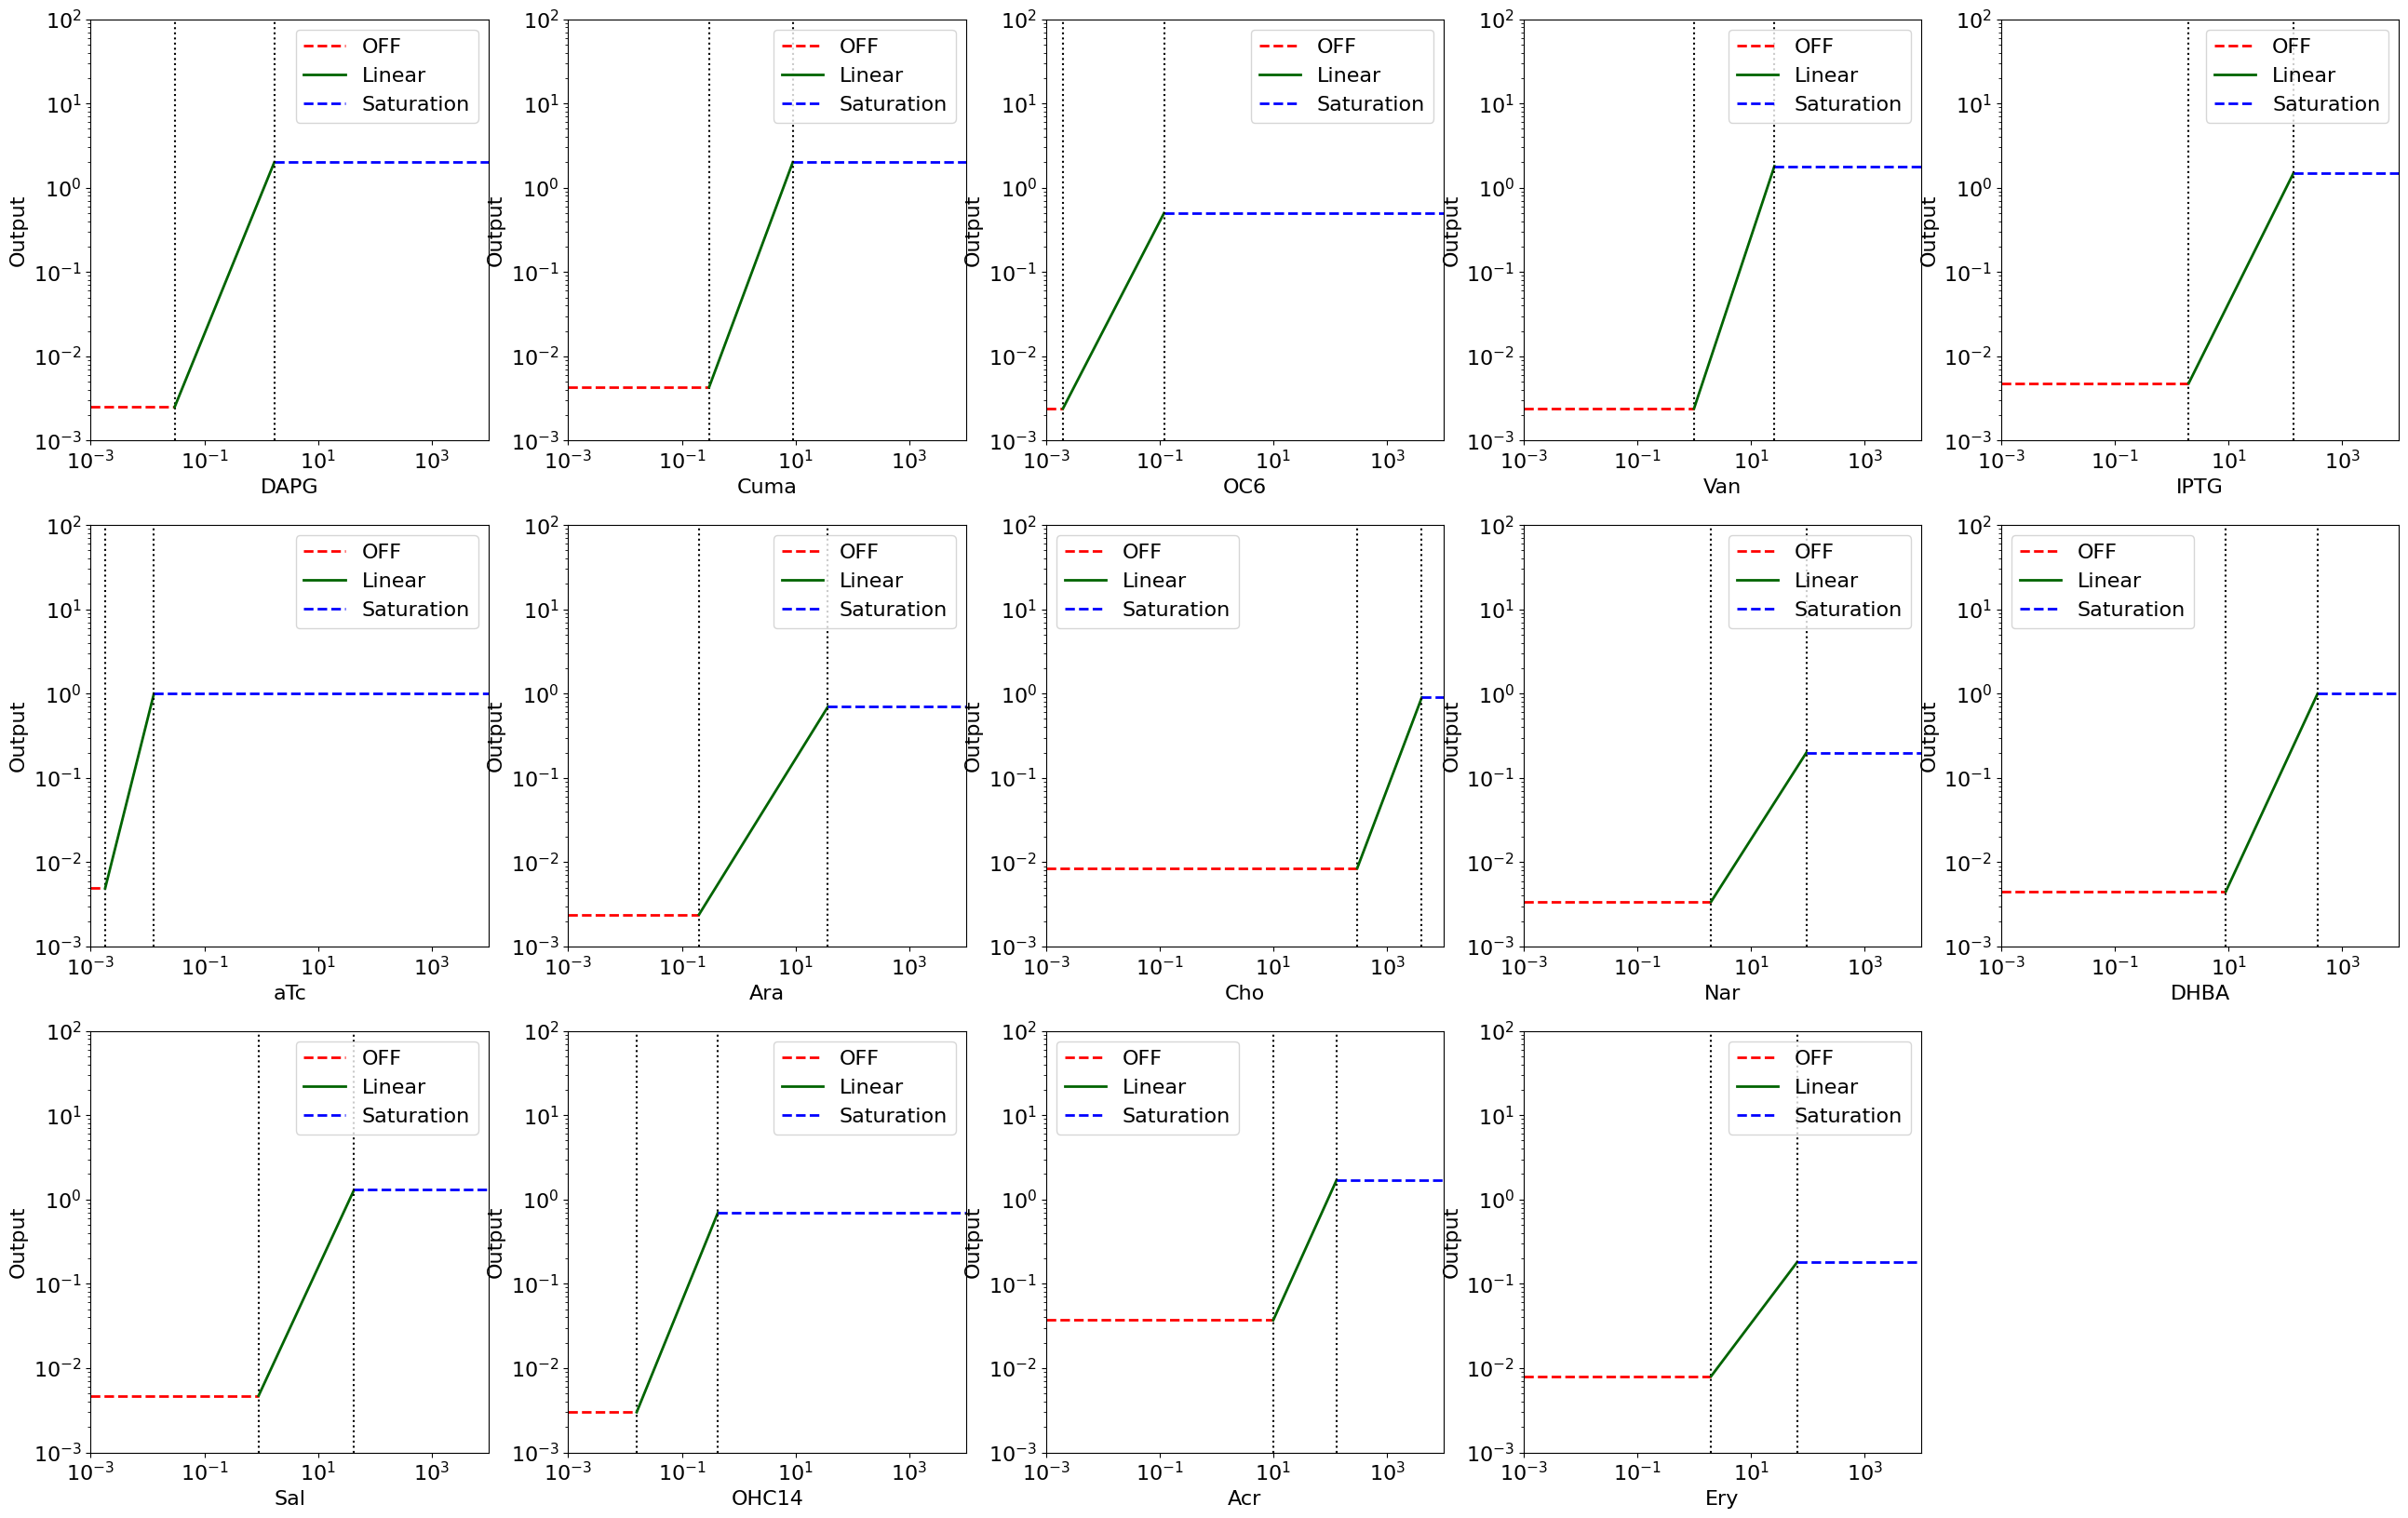

In [11]:
import matplotlib.pyplot as plt
from synbio_utils import display_sensor_contracts

fig, all_ax = plt.subplots(nrows=3, ncols=5, figsize=(32,20))
index = 0
for sensor in sensor_names:
    ax = all_ax[index // 5][index % 5]
    index += 1
    yleak_s = df.loc[df["Inducer"] == sensor]["ymin (RPUx10-3)"].values[0] * 1e-3
    s_start = df.loc[df["Inducer"] == sensor]["start"].values[0]
    s_K = df.loc[df["Inducer"] == sensor]["K (µM)"].values[0]
    ymax_s = df.loc[df["Inducer"] == sensor]["ymax Linear"].values[0]
    ax = display_sensor_contracts(
        sensor_input=sensor,
        output="",
        leak=yleak_s,
        start=s_start,
        K=s_K,
        ymax_lin=ymax_s,
        xlim_min=10**-3,
        xlim_max=10**4,
        ylim_min=10**-3,
        ylim_max=10**2,
        ax=ax,
        show=False,
    )
    ax.set_xlabel(sensor, fontsize=16)
    ax.tick_params(axis="both", which="major", labelsize=16)
    ax.set_ylabel("Output", fontsize=16)
    ax.legend(fontsize=16)
all_ax[2][4].set_axis_off()
# plt.savefig('all_sensors.svg')
plt.show()

Write the contract for the dCas9 repression mechanism

In [12]:
dCas9_contract_off = PolyhedralContract.from_string(
#             "xRFP:OFF, dCas9:OFF, RFP:ON",
            input_vars = [
                "xRFP", "dCas9"
            ],
            output_vars = [
                "RFP"
            ],
            assumptions = 
            [ 
                "xRFP <= 0.2",
                "dCas9 <= 0.1"
            ],
            guarantees = [
                "-RFP <= -10"
            ]
)

dCas9_contract_on = PolyhedralContract.from_string(
#             "The dCas9 repression: xRFP:ON, dCas9:ON, RFP:OFF",
            input_vars = [
                "xRFP", "dCas9"
            ],
            output_vars = [
                "RFP"
            ],
            assumptions = 
            [
                "-xRFP <= -0.3",
                "xRFP <= 1",
                "-dCas9 <= -0.1",
                "dCas9 <= 0.8"
            ],
            guarantees = [
                "RFP + 2xRFP + 0.1dCas9 <= 5" 
            ]
)

In [57]:
# Import Python symbolic computation library: sympy 
import sympy
# Import utility functions for this case study
from synbio_utils import display_sensor_contracts, remove_quantization_errors
# Import pacti PolyhedralContract parent for operations on guarantees
import pacti.terms.polyhedra as gtp

# Our 2nd input is aTc that outputs "dCas9"
# Create the contracts for this sensor using our `create_sensor_contracts` function
input2 = "aTc"
in2_params= sensor_library_params[input2]
c_atc_off, c_atc_on, c_atc_sat = create_sensor_contracts(sensor_input="aTc", output="dCas9", 
                                                         start=in2_params["start"],
                                                         K=in2_params["K"],
                                                         ymax_lin=in2_params["ymax"],
                                                         yleak=in2_params["leak"])
# Now we will go through all other sensors and find out which are OK to use given the context
sensor_ok = {}
# We will store all sensor names that are not compatible in a dictionary:
design_error = {}
# We will store the fold-change for all the sensors that are OK in this dictionary:
fold_change = {}
# Desired fold change: RFP_on/RFP_off
desired_fold_change = 4
# Go through all sensors in the library except aTc, since that has been chosen for the 2nd subsystem
for sensor in sensor_library:
    if sensor == "aTc":
        continue
    in1_params = sensor_library_params[sensor]   
    # OFF condition 
    # (note that RFP will be ON for this, so we will calculate "rfp_vals_on")
    c_sensor1 = sensor_library[sensor][0]
    c_sensor2 = c_atc_off
    # Compose the sensors together 
    # (if allowed! => Handle exceptions of the Pacti design error if composition is not allowed)
    try:
        sensor_comp = c_sensor2.compose(c_sensor1)
        top_level_off = sensor_comp.compose(dCas9_contract_off)
    except ValueError as e:
            # If Pacti raises a ValueError saying that the composition was 
            # "unsatisfiable in context", then that means that this sensor will not work!
            if "unsatisfiable in context" in str(e):
                sensor_ok[sensor] = False
    else:
        sensor_ok[sensor] = True
        # If the try block succeeds, this block runs
        # Remove quantization errors that are introduced in solving equations
        top_level_off = remove_quantization_errors(top_level_off)
        # Get the guarantee term and evaluate it
        sym_expr = gtp.PolyhedralTerm.to_symbolic(top_level_off.g.terms[0])
        rfp_vals_on = {}
        updated_sym = sym_expr.subs(sensor, 0.9*in1_params["start"])
        updated_sym = updated_sym.subs(input2, 0.9*in2_params["start"])
        subs_val = sympy.solve(updated_sym, "RFP")
        rfp_vals_on[in1_params["start"], in2_params["start"]] = subs_val[0]

    # ON condition
    # (note that RFP will be OFF for this, so we will calculate "rfp_vals_off")
    c_sensor1 = sensor_library[sensor][1]
    c_sensor2 = c_atc_on
    # Compose the sensors together 
    # (if allowed! => Handle exceptions of the Pacti design error if composition is not allowed)
    try:
        sensor_comp = c_sensor2.compose(c_sensor1)
        top_level_on = sensor_comp.compose(dCas9_contract_on)
    except ValueError as e:
            # If Pacti raises a ValueError saying that the composition was 
            # "unsatisfiable in context", then that means that this sensor will not work!
            if "unsatisfiable in context" in str(e):
                design_error[sensor] = False
    else:
        design_error[sensor] = True
        # If the try block succeeds, this block runs
        # Remove quantization errors that are introduced in solving equations
        top_level_on = remove_quantization_errors(top_level_on)
        # Get the guarantee term and evaluate it
        sym_expr = gtp.PolyhedralTerm.to_symbolic(top_level_on.g.terms[0])
        rfp_vals_off = {}
        updated_sym = sym_expr.subs(sensor, 0.9*in1_params["K"])
        updated_sym = updated_sym.subs(input2, 0.9*in2_params["K"])
        subs_val = sympy.solve(updated_sym, "RFP")
        rfp_vals_off[in1_params["K"], in2_params["K"]] = subs_val[0]
    # Now that we have rfp_vals_on and rfp_vals_off, we can compute the fold change:
    if design_error[sensor]:
        fold_change[sensor] = list(rfp_vals_on.values())[0]/list(rfp_vals_off.values())[0]
        if fold_change[sensor] > desired_fold_change:
            sensor_ok[sensor] = True
        else:
            sensor_ok[sensor] = False

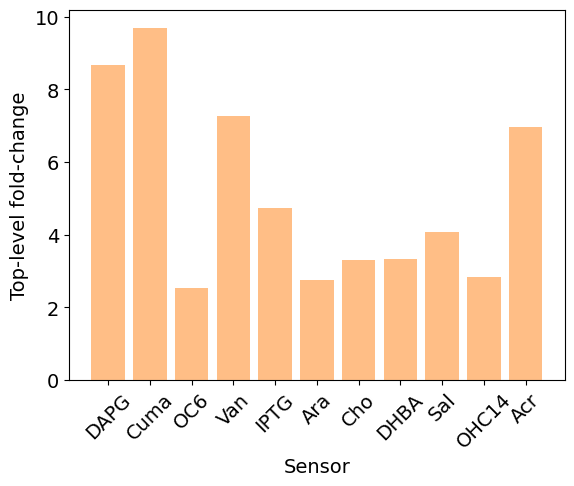

In [58]:
fig, ax = plt.subplots()
ax.bar(fold_change.keys(), fold_change.values(), color="C1", alpha=0.5)

ax.set_xlabel("Sensor", fontsize=14)
ax.set_ylabel("Top-level fold-change", fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Result

Choose subsystem 1 using the above exploration chart as the sensor that gives the highest-fold change:

We choose "Cuma" with the contract:

In [59]:
for contract in sensor_library["Cuma"]:
    print(contract)

InVars: [Cuma]
OutVars:[xRFP]
A: [
  Cuma <= 0.3
]
G: [
  xRFP <= 0.0042999999999999705
]
InVars: [Cuma]
OutVars:[xRFP]
A: [
  Cuma <= 8.9
  -Cuma <= -0.3
]
G: [
  0.23205813953488375 Cuma - xRFP = -0.06531744186046518
]
InVars: [Cuma]
OutVars:[xRFP]
A: [
  -Cuma <= -8.9
]
G: [
  -xRFP <= -2.0
]


Note that not all sensors were compatible. Some of the sensor choices led to errors in design automatically caught by _Pacti_ :

In [60]:
fold_change

{'DAPG': 8.66785005774809,
 'Cuma': 9.68674395539190,
 'OC6': 2.52677363203287,
 'Van': 7.26517302130202,
 'IPTG': 4.72491416737617,
 'Ara': 2.76605435260938,
 'Cho': 3.30535361336978,
 'DHBA': 3.32963257502971,
 'Sal': 4.07634004092162,
 'OHC14': 2.83319542816097,
 'Acr': 6.97093280769728}

In [61]:
sensor_ok

{'DAPG': True,
 'Cuma': True,
 'OC6': False,
 'Van': True,
 'IPTG': True,
 'Ara': False,
 'Cho': False,
 'Nar': True,
 'DHBA': False,
 'Sal': True,
 'OHC14': False,
 'Acr': True,
 'Ery': True}

# Finding specifications of missing parts

For the NAND gate described above, if we write a desired top-level contract $C_{\text{sys}}$ and assume that both sensors have been chosen (here we choose Sal and aTc) so that we have the contracts for both sensors. Then, we may use quotient operation in _Pacti_ to find the ideal specifications of the dCas9 mechanism. This can guide the design of the repression mechanism.


### Contract for Sal sensor:

In [18]:
yleak_sal = df.loc[df["Inducer"] == "Sal"]["ymin (RPUx10-3)"].values[0] * 1e-3
sal_start = df.loc[df["Inducer"] == "Sal"]["start"].values[0]
sal_K = df.loc[df["Inducer"] == "Sal"]["K (µM)"].values[0]
ymax_sal = df.loc[df["Inducer"] == "Sal"]["ymax Linear"].values[0]

sal_output = "xRFP"
contract_sal_min, contract_sal_lin, contract_sal_max = create_sensor_contracts(
    sensor_input="Sal", output=sal_output, start=sal_start, K=sal_K, ymax_lin=ymax_sal, yleak=yleak_sal
)

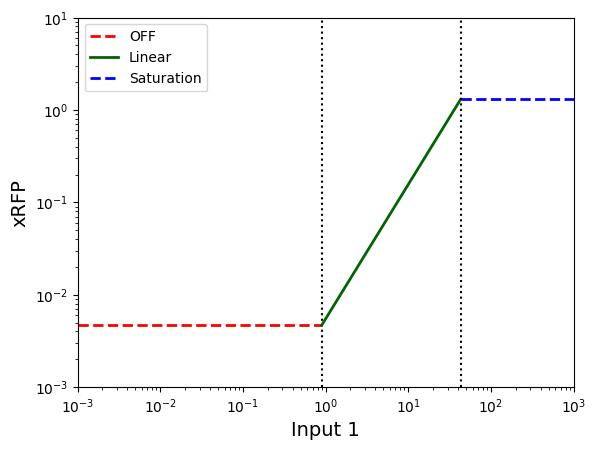

In [19]:
display_sensor_contracts(
    sensor_input="Input 1",
    output="xRFP",
    leak=yleak_sal,
    start=sal_start,
    K=sal_K,
    ymax_lin=ymax_sal,
    xlim_min=10**-3,
    xlim_max=10**3,
    ylim_min=10**-3,
    ylim_max=10**1,
);

### Contracts for aTc sensor

In [20]:
yleak_atc = df.loc[df["Inducer"] == "aTc"]["ymin (RPUx10-3)"].values[0] * 1e-3
atc_start = df.loc[df["Inducer"] == "aTc"]["start"].values[0]
atc_K = df.loc[df["Inducer"] == "aTc"]["K (µM)"].values[0]
ymax_atc = df.loc[df["Inducer"] == "aTc"]["ymax Linear"].values[0]
atc_output = "dCas9"
contract_atc_min, contract_atc_lin, contract_atc_max = create_sensor_contracts(
    sensor_input="aTc", output=atc_output, start=atc_start, K=atc_K, ymax_lin=ymax_atc, yleak=yleak_atc
)

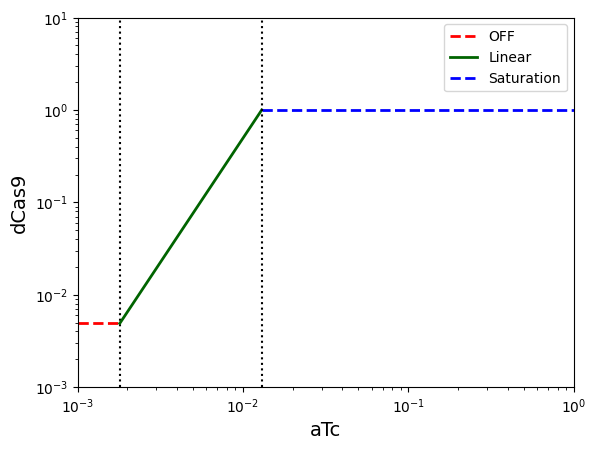

In [21]:
display_sensor_contracts(
    sensor_input="aTc",
    output="dCas9",
    leak=yleak_atc,
    start=atc_start,
    K=atc_K,
    ymax_lin=ymax_atc,
    xlim_min=10**-3,
    xlim_max=10**0,
    ylim_min=10**-3,
    ylim_max=10**1,
);

### Top-level system contract

In [22]:
import numpy as np
leak_RFP = np.max([yleak_atc, yleak_sal])
max_RFP = np.max([ymax_atc, ymax_sal])


def create_top_level_contracts(
    input1="u1", input2="u2", output="y", input1_params=None, input2_params=None, output_params=None
):
    """
    Creates the top level system contracts
    """
    u1_start = input1_params["start"]
    u1_K = input1_params["K"]

    u2_start = input2_params["start"]
    u2_K = input2_params["K"]

    y_max = output_params["max"]
    y_leak = output_params["leak"]
    all_contracts = []
    contract_top_level_on1 = PolyhedralContract.from_string(
#            "u1:OFF, u2:OFF, y:ON",
            input_vars = [
                input1, input2
            ],
            output_vars = [
                output
            ],
            assumptions = 
            [
                f"{input1} <= {u1_start - u1_start*0.01}",
                f"{input1} <= {u2_start - u2_start*0.01}"
            ],
            guarantees = [
                f"-{output}<={-1*y_max}",
            ]
    )
    all_contracts.append(contract_top_level_on1)
    contract_top_level_on2 = PolyhedralContract.from_string(
#             "u1:ON, u2:OFF, y:ON",
            input_vars = [
                input1, input2
            ],
            output_vars = [
                output
            ],
            assumptions = 
            [
                f"-{input1} <= {-1*(u1_start + u2_start*0.01)}",
                f"{input1} <= {u1_K - u1_K*0.01}",
                f"{input2} <= {u2_start - u2_start*0.01}"
            ],
            guarantees = [
                f"-{output} <= {-1*y_max}"
            ]
    )
    all_contracts.append(contract_top_level_on2)
    contract_top_level_on3 = PolyhedralContract.from_string(
#             "u1:OFF, u2:ON, y:ON",
            input_vars = [
                input1, input2
            ],
            output_vars = [
                output
            ],
            assumptions = 
            [
                f"{input1} <= {u1_start - u1_start*0.01}",
                f"-{input2} <= {-1*(u2_start + u2_start*0.01)}",
                f"{input2} <= {u2_K - u2_K*0.01}",
            ],
            guarantees = [
                f"-{output}<={-1*y_max}",
            ]
    )
    all_contracts.append(contract_top_level_on3)
    contract_top_level_off = PolyhedralContract.from_string(
#             "u1:ON, u2:ON, y:OFF",
            input_vars = [
                input1, input2
            ],
            output_vars = [
                output
            ],
            assumptions = 
            [
                f"-{input1} <= {-1*(u1_start + u1_start*0.01)}",
                f"{input1} <= {u1_K - u1_K*0.01}",
                f"-{input2} <= {-1*(u2_start + u2_start*0.01)}",
                f"{input2} <= {u2_K - u2_K*0.01}",
            ],
            guarantees = [
                f"{output} <= {y_leak}"   
            ]
    )
    all_contracts.append(contract_top_level_off)
    return all_contracts

In [23]:
sal_params = {"start":sal_start, "K":sal_K}
atc_params = {"start":atc_start, "K":atc_K}
RFP_params = {"max":max_RFP, "leak":leak_RFP}
ctop_off_off, ctop_on_off, ctop_off_on, ctop_on_on = create_top_level_contracts(input1 = "Sal",
                                                                                input2 = "aTc",
                                                                                output = "RFP",
                                                                                input1_params=sal_params,
                                                                                input2_params=atc_params,
                                                                                output_params=RFP_params)

### Print the contracts

In [24]:
print(contract_atc_lin)

InVars: [aTc]
OutVars:[dCas9]
A: [
  aTc <= 0.013
  -aTc <= -0.0018
]
G: [
  88.84821428571429 aTc - dCas9 = -0.15502678571428574
]


In [25]:
print(contract_sal_lin)

InVars: [Sal]
OutVars:[xRFP]
A: [
  Sal <= 43.0
  -Sal <= -0.9
]
G: [
  0.03076722090261283 Sal - xRFP = -0.0229904988123516
]


### Available composition 
(in the NAND gate ON condition => output is OFF)

In [26]:
print(contract_sal_lin.compose(contract_atc_lin))

InVars: [Sal, aTc]
OutVars:[xRFP, dCas9]
A: [
  Sal <= 43.0
  -Sal <= -0.9
  aTc <= 0.0129999999999999
  -aTc <= -0.0018000000000000238
]
G: [
  0.03076722090261283 Sal - xRFP = -0.0229904988123516
  88.84821428571429 aTc - dCas9 = -0.15502678571428574
]


In [27]:
print(ctop_on_on)

InVars: [Sal, aTc]
OutVars:[RFP]
A: [
  -Sal <= -0.909
  Sal <= 42.57
  -aTc <= -0.001818
  aTc <= 0.01287
]
G: [
  RFP <= 0.004899999999999904
]


#### Take the quotient of the top-level contract in the ON condition from the available composition

In [28]:
csal_atc = contract_sal_lin.compose(contract_atc_lin)
dCas_repression_lin = ctop_on_on.quotient(csal_atc)

## Result: We find the missing contract:

In [29]:
print(dCas_repression_lin)

InVars: [xRFP, dCas9]
OutVars:[RFP]
A: [
  -xRFP <= -0.05095790261282662
  xRFP <= 1.3327510926365798
  -dCas9 <= -0.3165528392857134
  dCas9 <= 1.2985033035714197
]
G: [
  RFP <= 0.004899999999999904
]


#### Find contract for the missing subsystem for other conditions of the NAND gate circuit:

In [30]:
print(contract_sal_min)

InVars: [Sal]
OutVars:[xRFP]
A: [
  Sal <= 0.9
]
G: [
  xRFP <= 0.0046999999999999265
]


In [31]:
print(contract_atc_lin)

InVars: [aTc]
OutVars:[dCas9]
A: [
  aTc <= 0.013
  -aTc <= -0.0018
]
G: [
  88.84821428571429 aTc - dCas9 = -0.15502678571428574
]


In [32]:
print(contract_sal_min.compose(contract_atc_lin))

InVars: [Sal, aTc]
OutVars:[xRFP, dCas9]
A: [
  Sal <= 0.8999999999999999
  aTc <= 0.0129999999999999
  -aTc <= -0.0018000000000000238
]
G: [
  xRFP <= 0.0046999999999999265
  88.84821428571429 aTc - dCas9 = -0.15502678571428574
]


In [33]:
print(ctop_off_on)

InVars: [Sal, aTc]
OutVars:[RFP]
A: [
  Sal <= 0.891
  -aTc <= -0.001818
  aTc <= 0.01287
]
G: [
  -RFP <= -1.3
]


In [34]:
csal_atc = contract_sal_min.compose(contract_atc_lin)
dCas_repression_off_on = ctop_off_on.quotient(csal_atc)

In [35]:
print(dCas_repression_off_on)

InVars: [xRFP, dCas9]
OutVars:[RFP]
A: [
  xRFP <= 0.0046999999999999265
  -dCas9 <= -0.3165528392857134
  dCas9 <= 1.2985033035714197
]
G: [
  -RFP <= -1.3
]


# Write results to a JSON file!

In [41]:
from pacti import write_contracts_to_file
system_json_contracts = write_contracts_to_file([dCas_repression_lin, dCas_repression_off_on],
                                                names=["dCas_Linear", "dCas_off_on"],
                                                file_name="dCas9_repression.json")